In [1]:
import numpy as np
import scipy as sp
import scipy.sparse
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from bayesbridge import BayesBridge
from simulate_data import simulate_design, simulate_outcome
from util import mcmc_summarizer

## BayesBridge supports both dense (numpy array) and sparse (scipy sparse matrix) design matrices.

In [3]:
n_obs, n_pred = 10 ** 4, 10 ** 3

X = simulate_design(
    n_obs, n_pred, 
    corr_dense_design=False,
    binary_frac=.6,
    binary_pred_freq=.2,
    categorical_frac=.3,
    n_category=5,
    shuffle_columns=True,
    format_='sparse',
    seed=111
)

In [4]:
beta_true = np.zeros(n_pred)
beta_true[:5] = 1.5
beta_true[5:10] = 1.
beta_true[10:15] = .5

n_trial = np.ones(X.shape[0]) # Binary outcome.
y = simulate_outcome(
    X, beta_true, intercept=0., 
    n_trial=n_trial, model='logit', seed=1
)

Optionally include the first 'n_coef_without_shrinkage' columns of the design matrix as fixed effects with Gaussian priors.

In [5]:
bridge = BayesBridge(
    y, X, model='logit',
    add_intercept=True, 
    center_predictor=True,
        # Do not manually add intercept to or center X.
    n_coef_without_shrinkage=0, 
        # Number of coefficients without shrinkage i.e. fixed effects
    prior_sd_for_intercept=float('inf'),
    prior_sd_for_unshrunk=float('inf'),
        # Set it to float('inf') for a flat prior.
    regularizing_slab_size=2.,
        # Weakly constrain the magnitude of coefficients under shrinkage.
)

## Run the Gibbs sampler. The BayesBridge uses a prior $ \pi(\beta_j \, | \, \tau) \propto \tau^{-1} \exp\left( - \, \left| \tau^{-1} \beta_j \right|^\alpha \right) $ for $0 < \alpha \leq 1$. The default is $\alpha = 1 / 2$.

In [6]:
mcmc_output = bridge.gibbs(
    n_burnin=0, n_post_burnin=250, thin=1, 
    init={'global_shrinkage': .01},
    sampling_method='cg',
    bridge_exponent=.5,
    seed=111
)
samples = mcmc_output['samples']

Check convergence by looking at the traceplot for posterior log-density.

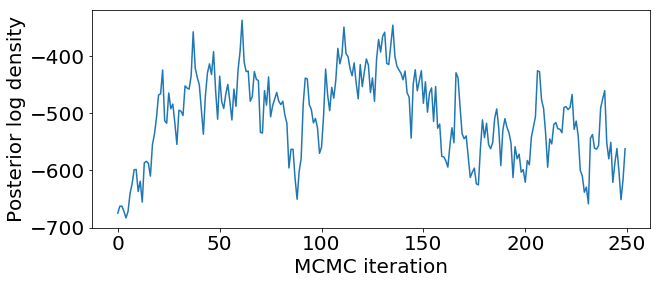

In [7]:
plt.figure(figsize=(10, 4))
plt.rcParams['font.size'] = 20

plt.plot(samples['logp'])
plt.xlabel('MCMC iteration')
plt.ylabel('Posterior log density')
plt.show()

## Restart MCMC from the last iteration with 'gibbs_additional_iter()'.

In [8]:
mcmc_output = bridge.gibbs_additional_iter(
    mcmc_output, n_iter=250
)

Add more samples (while keeping the previous ones) with 'merge=True'.

In [9]:
mcmc_output = bridge.gibbs_additional_iter(
    mcmc_output, n_iter=750, merge=True
)
samples = mcmc_output['samples']
coef_samples = samples['beta'][1:, :] # Extract all but the intercept

## Check mixing of regression coefficients and their posterior marginals.

Mixing of the global shrinkage parameter and hence of the log-density leave something to be desired for large-scale problems, but typically the convergence is quick and mixing of the regression coefficients is adequate.

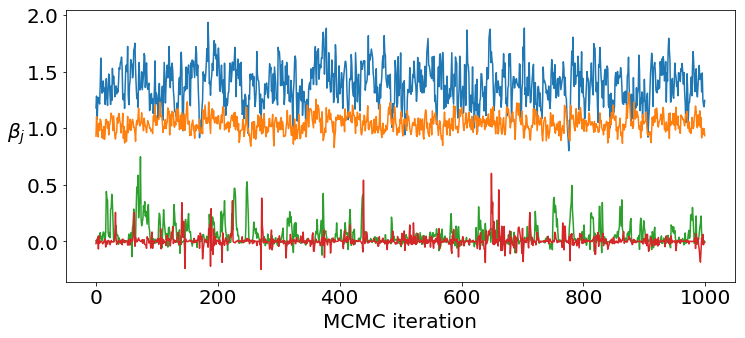

In [10]:
plt.figure(figsize=(12, 5))
plt.rcParams['font.size'] = 20

plt.plot(coef_samples[[0, 5, 10, 15], :].T)
plt.xlabel('MCMC iteration')
plt.ylabel(r'$\beta_j$', rotation=0, labelpad=10)
plt.show()

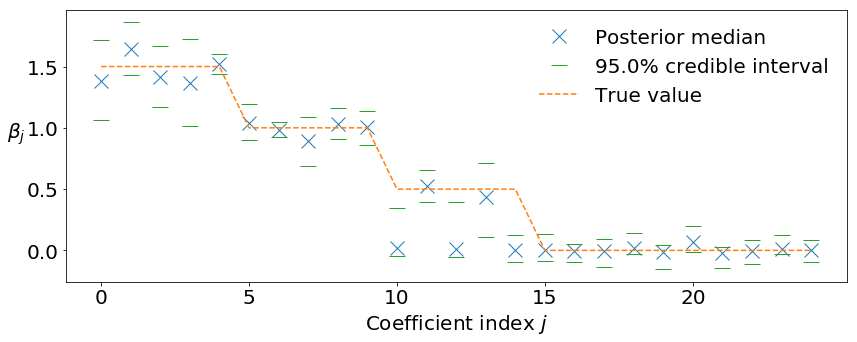

In [11]:
plt.figure(figsize=(14, 5))
plt.rcParams['font.size'] = 20

n_coef_to_plot = 25

mcmc_summarizer.plot_conf_interval(
    coef_samples, conf_level=.95, 
    n_coef_to_plot=n_coef_to_plot, marker_scale=1.4
);
plt.plot(
    beta_true[:n_coef_to_plot], '--', color='tab:orange',
    label='True value'
)
plt.xlabel(r'Coefficient index $j$')
plt.ylabel(r'$\beta_j$', rotation=0, labelpad=10)
plt.xticks([0, 5, 10, 15, 20])
plt.legend(frameon=False)

plt.show()